In [46]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [9]:
PROJECT_PATH = Path.cwd().parent
DATA_PATH = PROJECT_PATH / "dataset" / "train_FD001.csv"

print("Dataset path :", DATA_PATH)

Dataset path : c:\Users\venut\OneDrive\Desktop\predictive_maintenance\dataset\train_FD001.csv


In [10]:
df = pd.read_csv(DATA_PATH)
df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
max_cycle = df.groupby("engine_id")["cycle"].transform("max")
df["RUL"] = max_cycle - df["cycle"]

df[["engine_id", "cycle", "RUL"]].head()

,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [58]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_10",
    "sensor_16", "sensor_18", "sensor_19"
]

feature_cols = df.drop(
    columns=["engine_id", "cycle", "RUL"] + drop_sensors
).columns

In [59]:
engine_ids = df["engine_id"].unique()

train_engines, test_engines = train_test_split(
    engine_ids,
    test_size=0.2,
    random_state=42
)

train_df = df[df["engine_id"].isin(train_engines)]
test_df  = df[df["engine_id"].isin(test_engines)]

X_train = train_df[feature_cols]
y_train = train_df["RUL"]

X_test = test_df[feature_cols]
y_test = test_df["RUL"]


In [60]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Linear Regression Performance:")
print("MSE :", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("R2 Score :", r2_score(y_test, y_pred_lr))

Linear Regression Performance:
MSE : 38.132534801274744
MAE : 30.111252539998222
R2 Score : 0.6626376008508219


In [61]:
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

print("Ridge Regression Performance:")
print("MSE :", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAE :", mean_absolute_error(y_test, y_pred_ridge))
print("R2 Score :", r2_score(y_test, y_pred_ridge))


Ridge Regression Performance:
MSE : 38.13254931861154
MAE : 30.111262165617816
R2 Score : 0.6626373439780737


In [62]:
lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso())
])

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

print("Lasso Regression Performance:")
print("MSE :", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("MAE :", mean_absolute_error(y_test, y_pred_lasso))
print("R2 Score :", r2_score(y_test, y_pred_lasso))

Lasso Regression Performance:
MSE : 38.19772286168288
MAE : 30.17787862506332
R2 Score : 0.6614831641801842


In [63]:
rf = RandomForestRegressor(
    n_estimators = 100,
    random_state = 42,
    max_depth = 10,
    n_jobs = -1
)

rf.fit(X_train, y_train)
y_pres_rf = rf.predict(X_test)

print("Random Forest Performance:")
print("MSE :", np.sqrt(mean_squared_error(y_test, y_pres_rf)))
print("MAE :", mean_absolute_error(y_test, y_pres_rf))
print("R2 Score :", r2_score(y_test, y_pres_rf))

Random Forest Performance:
MSE : 35.3188169265341
MAE : 25.87058502407477
R2 Score : 0.710587275862022


In [64]:
groups = train_df["engine_id"]

cv = GroupKFold(n_splits=5)

scores = cross_val_score(
    rf,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    groups=groups
)
print(f"Random Forest CV RMSE: {-scores.mean():.2f}")


Random Forest CV RMSE: 44.44


In [65]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [8, 10, 12],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [66]:
y_pred_final = best_model.predict(X_test)

print("Final Tuned Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_final))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_final)))
print("R2:", r2_score(y_test, y_pred_final))

Final Tuned Random Forest
MAE: 25.865923449024763
RMSE: 35.30485354163289
R2: 0.7108160707520184


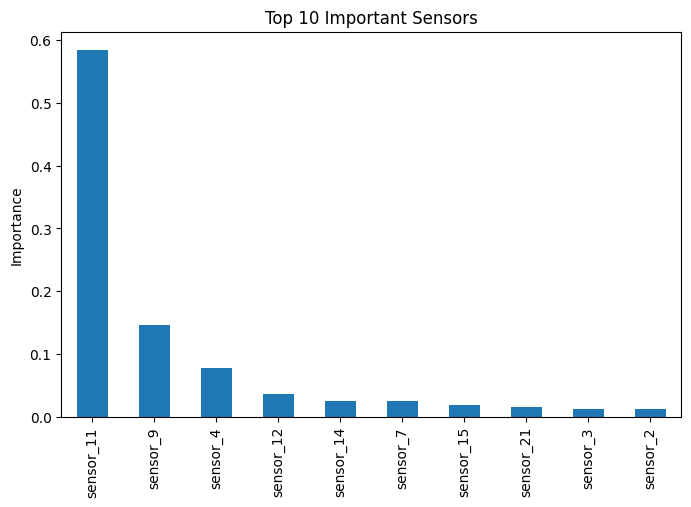

In [67]:
importances = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.head(10).plot(kind="bar")
plt.title("Top 10 Important Sensors")
plt.ylabel("Importance")
plt.show()


In [68]:
import joblib

MODEL_PATH = PROJECT_PATH / "models"
MODEL_PATH.mkdir(exist_ok=True)

# Save trained model
joblib.dump(best_model, MODEL_PATH / "rf_rul_model.pkl")

# Save feature column order
joblib.dump(list(feature_cols), MODEL_PATH / "feature_columns.pkl")

print("Model and feature columns saved successfully.")


Model and feature columns saved successfully.
